## Set up

In [31]:
from google.cloud import aiplatform
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'koa-biotech'

In [33]:
REGION = 'europe-west1'
model_id = '8316182584962842624'

In [34]:
aiplatform.init(project=PROJECT_ID, location=REGION)

In [35]:
model = aiplatform.Model(model_name=f"projects/{PROJECT_ID}/locations/{REGION}/models/{model_id}")

## Model Evaluation

### Confusion Matrix

In [36]:
model_evaluations = model.list_model_evaluations()

In [37]:
evaluation = model_evaluations[0].to_dict()

In [44]:
l = len(evaluation.get('metrics').get('confidenceMetrics'))
em = evaluation.get('metrics').get('confidenceMetrics')[l//2]
em

{'precisionAt1': 0.9411765,
 'recallAt1': 0.9411765,
 'truePositiveCount': '128',
 'f1ScoreAt1': 0.9411765,
 'falseNegativeCount': '8',
 'f1ScoreMicro': 0.9411765,
 'trueNegativeCount': '128',
 'recall': 0.9411765,
 'confidenceThreshold': 0.5,
 'falsePositiveRate': 0.05882353,
 'falsePositiveCount': '8',
 'precision': 0.9411765,
 'f1ScoreMacro': 0.89880955,
 'f1Score': 0.9411765,
 'confusionMatrix': {'annotationSpecs': [{'displayName': 'true', 'id': '0'},
   {'displayName': 'false', 'id': '1'},
   {'id': 'DROPPED', 'displayName': 'DROPPED'}],
  'rows': [[108.0, 6.0, 0.0], [2.0, 20.0, 0.0], [0.0, 0.0, 0.0]]},
 'falsePositiveRateAt1': 0.05882353}

In [38]:
cm = em.get('confusionMatrix')

In [39]:
cm_rows = list(cm.get('rows'))[:-1]
anot = cm.get('annotationSpecs')
labels = [val['displayName'] for val in anot]
cm_df = pd.DataFrame(cm_rows,
                     columns=labels,
                     index=labels[:-1])
cm_df.columns = pd.MultiIndex.from_product([['predicted'], cm_df.columns])
cm_df.index = pd.MultiIndex.from_product([['actual'], cm_df.index])
cm_df

predicted              
                  true false DROPPED
actual true      108.0   6.0     0.0
       false       2.0  20.0     0.0

In [40]:
TN = cm_df.loc[('actual', 'false'), ('predicted', 'false')]
FP = cm_df.loc[('actual', 'false'), ('predicted', 'true')]
FN = cm_df.loc[('actual', 'true'), ('predicted', 'false')]
TP = cm_df.loc[('actual', 'true'), ('predicted', 'true')]

### Metrics

In [41]:
acc = 100*(TP+TN)/(TP+TN+FP+FN)
precision = 100*TP/(TP+FP)
recall = 100*TP/(TP+FN)
fallout = 100*FP/(TN+FP)
_for = 100*FN/(TN+FN)
tnr = 100 - _for
balanced_acc = (tnr + recall)/2
f1 = 2*(precision*recall)/(precision+recall)

### Insights

In [42]:
print(f'The overall model accuracy is {acc:.2f}%')
print(f'The overall model balanced accuracy is {balanced_acc:.2f}%')

The overall model accuracy is 94.12%
The overall model balanced accuracy is 85.83%


In [43]:
print(f'Given that there is a pathogen in the sample, the model is {recall:.2f}% likely to detect it.')
print(f'Given that there is no pathogen in the sample, the model is {fallout:.2f}% likely to wrongly detect it.')

Given that there is a pathogen in the sample, the model is 94.74% likely to detect it.
Given that there is no pathogen in the sample, the model is 9.09% likely to wrongly detect it.


In [30]:
print(f'Given that the model gave a positive result (pathogen), the sample is {precision:.2f}% likely to have a pathogen.')
print(f'Given that the model gave a negative result (no pathogen), the sample is still {_for:.2f}% likely to have a pathogen.')

Given that the model gave a positive result (pathogen), the sample is 98.18% likely to have a pathogen.
Given that the model gave a negative result (no pathogen), the sample is still 23.08% likely to have a pathogen.


## Feature Importances

In [26]:
explanation = evaluation.get('modelExplanation')

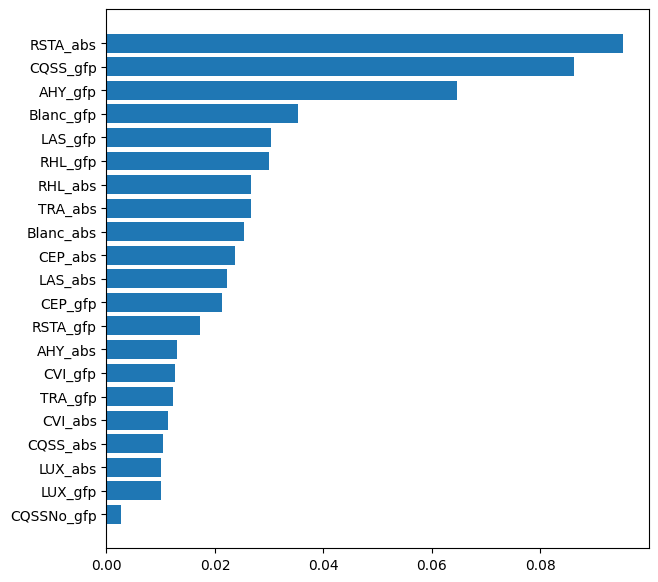

In [32]:
features = []
scores = []
for k in explanation.get('meanAttributions')[0].get('featureAttributions'):
    features.append(k)
    scores.append(explanation.get('meanAttributions')[0].get('featureAttributions')[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
ax.barh(features, scores)
fig.show()